In [1]:
import pandas as pd

file_path = "documents_full_data.csv"
df = pd.read_csv(file_path)

In [2]:
print(df.columns)

Index(['id', 'display_name', 'doi', 'title', 'publication_year',
       'publication_date', 'topics', 'primary_topic', 'keywords',
       'cited_by_count', 'related_works', 'concepts',
       'abstract_inverted_index', 'best_oa_location', 'text_abstract',
       'extracted_topics', 'extracted_concepts', 'extracted_domains'],
      dtype='object')


In [4]:
print(df.iloc[0]['publication_date'])

2010-09-26


In [3]:
import ast

df = df.dropna(subset=['publication_date'])

df['date'] = pd.to_datetime(df['publication_date'], errors='coerce')

df['extracted_topics'] = df['extracted_topics'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

df = df[df['extracted_topics'].astype(bool)]  

df_exploded = df.explode('extracted_topics')

monthly_counts = (df_exploded
    .groupby(['extracted_topics', pd.Grouper(key='date', freq='M')])
    .size()
    .reset_index(name='count')
    .sort_values('date')
)

monthly_counts.head()


,extracted_topics,date,count
82334,Botany and Plant Ecology Studies,1683-01-31,1
22565,Advanced Theoretical and Applied Studies in Ma...,1686-09-30,1
360358,Manufacturing Process and Optimization,1686-09-30,1
18269,Advanced Numerical Analysis Techniques,1686-09-30,1
183323,Educational and Social Studies,1687-01-31,1


In [15]:
topic_totals = monthly_counts.groupby('extracted_topics')['count'].sum().reset_index()
topic_totals = topic_totals.sort_values('count', ascending=False)

top_12_topics = topic_totals.head(12)['extracted_topics'].tolist()

print("Top 12 Topics:", top_12_topics)


Top 12 Topics: ['Topic Modeling', 'Natural Language Processing Techniques', 'Speech Recognition and Synthesis', 'Music and Audio Processing', 'Speech and Audio Processing', 'Immune Cell Function and Interaction', 'Comparative Literary Analysis and Criticism', 'Multimodal Machine Learning Applications', 'Advanced Text Analysis Techniques', 'Speech and dialogue systems', 'Generative Adversarial Networks and Image Synthesis', 'T-cell and B-cell Immunology']


In [25]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def lstm_forecast_for_topic(df_counts, topic, lookback=3, test_size=6):    
    df_topic = df_counts[df_counts['extracted_topics'] == topic].copy()
    min_date = df_counts['date'].min()
    max_date = df_counts['date'].max()
    full_range = pd.date_range(start=min_date, end=max_date, freq='M')
    
    df_topic = df_topic.set_index('date').reindex(full_range, fill_value=0)
    df_topic = df_topic.rename(columns={'count': 'y'})
    df_topic['date'] = df_topic.index
    
    df_topic = df_topic.sort_values('date')
    
    series_values = df_topic['y'].values.reshape(-1, 1)
    
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series_values)
    
    def create_sequences(data, lookback):
        X, y = [], []
        for i in range(len(data) - lookback):
            X.append(data[i : i + lookback, 0])
            y.append(data[i + lookback, 0])
        return np.array(X), np.array(y)
    
    X_all, y_all = create_sequences(series_scaled, lookback=lookback)
    
    train_end = len(X_all) - test_size
    X_train, X_test = X_all[:train_end], X_all[train_end:]
    y_train, y_test = y_all[:train_end], y_all[train_end:]
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test  = np.reshape(X_test,  (X_test.shape[0], X_test.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(32, input_shape=(lookback, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0)
    
    y_pred_test = model.predict(X_test)
    
    y_pred_test_inv = scaler.inverse_transform(y_pred_test)
    y_test_inv      = scaler.inverse_transform(y_test.reshape(-1,1))
    
    test_dates = df_topic['date'][-test_size:]
    
    plt.figure()
    plt.plot(test_dates, y_test_inv, label='Actual', marker='o')
    plt.plot(test_dates, y_pred_test_inv, label='Predicted', marker='o')
    plt.title(f'LSTM Forecast for Topic: {topic}')
    plt.xlabel('Date')
    plt.ylabel('Monthly Paper Count')
    plt.legend()
    plt.show()
    
    mae = np.mean(np.abs(y_test_inv.flatten() - y_pred_test_inv.flatten()))
    mape = np.mean(np.abs((y_test_inv.flatten() - y_pred_test_inv.flatten()) / (y_test_inv.flatten() + 1e-10))) * 100
    
    print(f"Topic: {topic} | Test MAE: {mae:.2f} | Test MAPE: {mape:.2f}%")
    
    return model, (y_test_inv, y_pred_test_inv)


=== Forecasting for topic: Topic Modeling ===


2025-03-03 00:08:47.172371: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-03-03 00:08:47.172408: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-03-03 00:08:47.172443: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ise-cpu-intl-14): /proc/driver/nvidia/version does not exist


1/1 [==============================] - 5s 5s/step


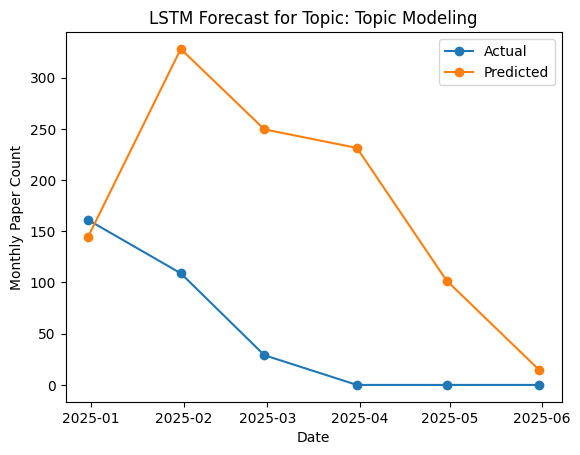

Topic: Topic Modeling | Test MAE: 133.94 | Test MAPE: 57992518266203.95%


In [26]:
for t in top_10_topics:
    print("=== Forecasting for topic:", t, "===")
    model, results = lstm_forecast_for_topic(monthly_counts, t, lookback=3, test_size=6)
    break


In [22]:
def safe_mape(y_true, y_pred):
    mask = y_true != 0  
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def lstm_forecast_for_topic(df_counts, topic, lookback, test_size, lstm_units, batch_size, learning_rate, epochs):
    df_topic = df_counts[df_counts['extracted_topics'] == topic].copy()
    
    min_date = df_counts['date'].min()
    max_date = df_counts['date'].max()
    full_range = pd.date_range(start=min_date, end=max_date, freq='M')
    
    df_topic = df_topic.set_index('date').reindex(full_range, fill_value=0)
    df_topic = df_topic.rename(columns={'count': 'y'})
    df_topic['date'] = df_topic.index
    df_topic = df_topic.sort_values('date')
    
    series_values = df_topic['y'].values.reshape(-1, 1)
    
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series_values)
    
    def create_sequences(data, lookback):
        X, y = [], []
        for i in range(len(data) - lookback):
            X.append(data[i : i + lookback, 0])
            y.append(data[i + lookback, 0])
        return np.array(X), np.array(y)
    
    X_all, y_all = create_sequences(series_scaled, lookback=lookback)
    
    train_end = len(X_all) - test_size
    X_train, X_test = X_all[:train_end], X_all[train_end:]
    y_train, y_test = y_all[:train_end], y_all[train_end:]
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test  = np.reshape(X_test,  (X_test.shape[0], X_test.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(lookback, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=learning_rate))
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    y_pred_test = model.predict(X_test)
    
    y_pred_test_inv = scaler.inverse_transform(y_pred_test)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
    
    mae = np.mean(np.abs(y_test_inv.flatten() - y_pred_test_inv.flatten()))
    rmse = np.sqrt(np.mean((y_test_inv.flatten() - y_pred_test_inv.flatten())**2))
    mape = safe_mape(y_test_inv.flatten(), y_pred_test_inv.flatten())
    
    return model, mae, rmse, mape, y_test_inv, y_pred_test_inv, df_topic['date'][-test_size:]


In [8]:
def objective(trial):

    lookback = trial.suggest_int("lookback", 2, 6)  
    lstm_units = trial.suggest_int("lstm_units", 16, 128, step=16)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    epochs = trial.suggest_int("epochs", 20, 100, step=10)
    
    topic = top_10_topics[0] 

    _, mae, _, _, _ = lstm_forecast_for_topic(monthly_counts, topic, lookback, test_size=6,
                                              lstm_units=lstm_units, batch_size=batch_size,
                                              learning_rate=learning_rate, epochs=epochs)
    
    return mae 

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  

best_params = study.best_params
print("Best Hyperparameters:", best_params)

best_params_file = "best_hyperparameters.txt"

with open(best_params_file, "w") as f:
    f.write("Best Hyperparameters from Optuna Optimization:\n")
    for key, value in best_params.items():
        f.write(f"{key}: {value}\n")

print(f"Best parameters saved to {best_params_file}")



[I 2025-03-03 01:15:06,622] A new study created in memory with name: no-name-a80bb211-4d62-4a46-bd7c-a50069fbfcd8
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 0s 484ms/step


[I 2025-03-03 01:15:45,997] Trial 0 finished with value: 47.10845669110616 and parameters: {'lookback': 4, 'lstm_units': 80, 'batch_size': 32, 'learning_rate': 0.0009718363681560022, 'epochs': 60}. Best is trial 0 with value: 47.10845669110616.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 1s 664ms/step


[I 2025-03-03 01:16:27,123] Trial 1 finished with value: 56.78378995259603 and parameters: {'lookback': 6, 'lstm_units': 80, 'batch_size': 16, 'learning_rate': 0.0007374404547853975, 'epochs': 30}. Best is trial 0 with value: 47.10845669110616.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 0s 473ms/step


[I 2025-03-03 01:17:28,041] Trial 2 finished with value: 58.13488515218099 and parameters: {'lookback': 6, 'lstm_units': 16, 'batch_size': 16, 'learning_rate': 0.0010416637809509497, 'epochs': 60}. Best is trial 0 with value: 47.10845669110616.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 0s 459ms/step


[I 2025-03-03 01:18:17,881] Trial 3 finished with value: 30.04709207514922 and parameters: {'lookback': 2, 'lstm_units': 16, 'batch_size': 16, 'learning_rate': 0.00016528957889800424, 'epochs': 80}. Best is trial 3 with value: 30.04709207514922.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 0s 461ms/step


[I 2025-03-03 01:19:18,233] Trial 4 finished with value: 109.74317677815755 and parameters: {'lookback': 6, 'lstm_units': 96, 'batch_size': 32, 'learning_rate': 0.006846996031466402, 'epochs': 70}. Best is trial 3 with value: 30.04709207514922.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 0s 447ms/step


[I 2025-03-03 01:19:42,727] Trial 5 finished with value: 53.60361131032308 and parameters: {'lookback': 4, 'lstm_units': 32, 'batch_size': 32, 'learning_rate': 0.00016877156195164596, 'epochs': 50}. Best is trial 3 with value: 30.04709207514922.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 0s 452ms/step


[I 2025-03-03 01:20:16,976] Trial 6 finished with value: 39.935250441233315 and parameters: {'lookback': 3, 'lstm_units': 96, 'batch_size': 32, 'learning_rate': 0.0001093097496717247, 'epochs': 60}. Best is trial 3 with value: 30.04709207514922.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 0s 449ms/step


[I 2025-03-03 01:20:33,932] Trial 7 finished with value: 49.54464991887411 and parameters: {'lookback': 3, 'lstm_units': 32, 'batch_size': 64, 'learning_rate': 0.0007515143080132676, 'epochs': 70}. Best is trial 3 with value: 30.04709207514922.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 0s 460ms/step


[I 2025-03-03 01:21:41,280] Trial 8 finished with value: 71.50484148661296 and parameters: {'lookback': 6, 'lstm_units': 128, 'batch_size': 32, 'learning_rate': 0.0032482007723372832, 'epochs': 50}. Best is trial 3 with value: 30.04709207514922.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 0s 457ms/step


[I 2025-03-03 01:22:03,673] Trial 9 finished with value: 31.517993800342083 and parameters: {'lookback': 2, 'lstm_units': 80, 'batch_size': 64, 'learning_rate': 0.000696600700697114, 'epochs': 70}. Best is trial 3 with value: 30.04709207514922.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 0s 484ms/step


[I 2025-03-03 01:24:09,641] Trial 10 finished with value: 34.14318630347649 and parameters: {'lookback': 2, 'lstm_units': 48, 'batch_size': 8, 'learning_rate': 0.00023658358461279078, 'epochs': 100}. Best is trial 3 with value: 30.04709207514922.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 0s 445ms/step


[I 2025-03-03 01:24:31,387] Trial 11 finished with value: 33.59068742394447 and parameters: {'lookback': 2, 'lstm_units': 64, 'batch_size': 64, 'learning_rate': 0.00032755959250189623, 'epochs': 90}. Best is trial 3 with value: 30.04709207514922.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 0s 452ms/step


[I 2025-03-03 01:25:06,762] Trial 12 finished with value: 31.63658817609151 and parameters: {'lookback': 2, 'lstm_units': 128, 'batch_size': 64, 'learning_rate': 0.0003781635172777404, 'epochs': 80}. Best is trial 3 with value: 30.04709207514922.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 0s 480ms/step


[I 2025-03-03 01:26:20,596] Trial 13 finished with value: 59.28867834806442 and parameters: {'lookback': 3, 'lstm_units': 64, 'batch_size': 16, 'learning_rate': 0.0023939783391657525, 'epochs': 90}. Best is trial 3 with value: 30.04709207514922.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 0s 447ms/step


[I 2025-03-03 01:26:47,579] Trial 14 finished with value: 35.00270215794444 and parameters: {'lookback': 2, 'lstm_units': 16, 'batch_size': 8, 'learning_rate': 0.00010713897227814733, 'epochs': 20}. Best is trial 3 with value: 30.04709207514922.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 0s 480ms/step


[I 2025-03-03 01:27:36,032] Trial 15 finished with value: 77.3988265991211 and parameters: {'lookback': 5, 'lstm_units': 96, 'batch_size': 64, 'learning_rate': 0.0016607893542716933, 'epochs': 80}. Best is trial 3 with value: 30.04709207514922.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 1s 774ms/step


[I 2025-03-03 01:28:08,775] Trial 16 finished with value: 50.40191920598348 and parameters: {'lookback': 3, 'lstm_units': 48, 'batch_size': 16, 'learning_rate': 0.0004595928898567935, 'epochs': 40}. Best is trial 3 with value: 30.04709207514922.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 1s 732ms/step


[I 2025-03-03 01:29:16,281] Trial 17 finished with value: 33.221315026283264 and parameters: {'lookback': 2, 'lstm_units': 112, 'batch_size': 16, 'learning_rate': 0.00020596560763213063, 'epochs': 80}. Best is trial 3 with value: 30.04709207514922.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 0s 469ms/step


[I 2025-03-03 01:29:50,519] Trial 18 finished with value: 66.1043332417806 and parameters: {'lookback': 5, 'lstm_units': 48, 'batch_size': 64, 'learning_rate': 0.0071997623300413234, 'epochs': 100}. Best is trial 3 with value: 30.04709207514922.
/tmp/ipykernel_3408880/1399648195.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


1/1 [==============================] - 1s 899ms/step


[I 2025-03-03 01:31:31,948] Trial 19 finished with value: 43.74432293574015 and parameters: {'lookback': 3, 'lstm_units': 32, 'batch_size': 8, 'learning_rate': 0.0005053879770634241, 'epochs': 70}. Best is trial 3 with value: 30.04709207514922.


Best Hyperparameters: {'lookback': 2, 'lstm_units': 16, 'batch_size': 16, 'learning_rate': 0.00016528957889800424, 'epochs': 80}
Best parameters saved to best_hyperparameters.txt


Training final model with best parameters on best topic...
1/1 [==============================] - 0s 469ms/step


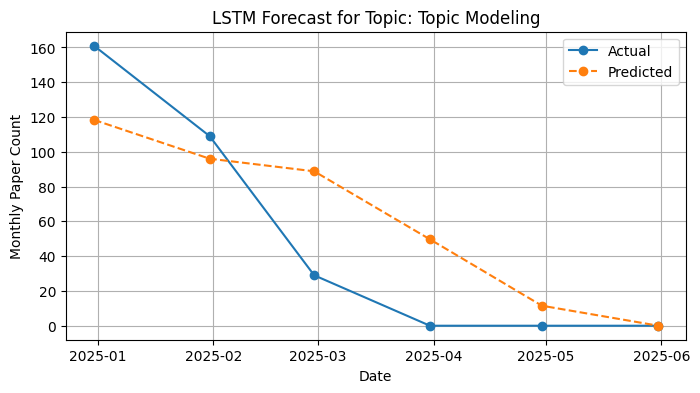

Final Model Performance for Topic Modeling: MAE = 29.45


In [25]:
print("Training final model with best parameters on best topic...")

best_lookback = best_params["lookback"]
best_lstm_units = best_params["lstm_units"]
best_batch_size = best_params["batch_size"]
best_learning_rate = best_params["learning_rate"]
best_epochs = best_params["epochs"]

final_topic = top_10_topics[0]  

model, mae, rmse, mape, y_test_inv, y_pred_test_inv, test_dates = \
    lstm_forecast_for_topic(monthly_counts, final_topic, best_lookback, test_size=6, 
                            lstm_units=best_lstm_units, batch_size=best_batch_size, 
                            learning_rate=best_learning_rate, epochs=best_epochs)

plt.figure(figsize=(8,4))
plt.plot(final_test_dates, final_y_test_inv, label='Actual', marker='o', linestyle='-')
plt.plot(final_test_dates, final_y_pred_test_inv, label='Predicted', marker='o', linestyle='--')
plt.title(f'LSTM Forecast for Topic: {final_topic}')
plt.xlabel('Date')
plt.ylabel('Monthly Paper Count')
plt.legend()
plt.grid()
plt.savefig('Monthly Paper Count.png')
plt.show()
print(f"Final Model Performance for {final_topic}: MAE = {final_mae:.2f}")

In [27]:
print(best_params)

{'lookback': 2, 'lstm_units': 16, 'batch_size': 16, 'learning_rate': 0.00016528957889800424, 'epochs': 80}


=== Forecasting for topic: Topic Modeling ===
1/1 [==============================] - 0s 462ms/step
=== Forecasting for topic: Natural Language Processing Techniques ===


/tmp/ipykernel_3408880/189342066.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_dates, rotation=45, ha='right')


1/1 [==============================] - 0s 483ms/step
=== Forecasting for topic: Speech Recognition and Synthesis ===


/tmp/ipykernel_3408880/189342066.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_dates, rotation=45, ha='right')


1/1 [==============================] - 0s 434ms/step
=== Forecasting for topic: Music and Audio Processing ===


/tmp/ipykernel_3408880/189342066.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_dates, rotation=45, ha='right')


1/1 [==============================] - 0s 440ms/step
=== Forecasting for topic: Speech and Audio Processing ===


/tmp/ipykernel_3408880/189342066.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_dates, rotation=45, ha='right')


1/1 [==============================] - 0s 493ms/step
=== Forecasting for topic: Immune Cell Function and Interaction ===


/tmp/ipykernel_3408880/189342066.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_dates, rotation=45, ha='right')


1/1 [==============================] - 0s 479ms/step
=== Forecasting for topic: Comparative Literary Analysis and Criticism ===


/tmp/ipykernel_3408880/189342066.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_dates, rotation=45, ha='right')


1/1 [==============================] - 1s 518ms/step
=== Forecasting for topic: Multimodal Machine Learning Applications ===


/tmp/ipykernel_3408880/189342066.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_dates, rotation=45, ha='right')


1/1 [==============================] - 0s 461ms/step
=== Forecasting for topic: Advanced Text Analysis Techniques ===


/tmp/ipykernel_3408880/189342066.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_dates, rotation=45, ha='right')


1/1 [==============================] - 0s 459ms/step
=== Forecasting for topic: Speech and dialogue systems ===


/tmp/ipykernel_3408880/189342066.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_dates, rotation=45, ha='right')


1/1 [==============================] - 0s 461ms/step
=== Forecasting for topic: Generative Adversarial Networks and Image Synthesis ===


/tmp/ipykernel_3408880/189342066.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_dates, rotation=45, ha='right')


1/1 [==============================] - 0s 457ms/step
=== Forecasting for topic: T-cell and B-cell Immunology ===


/tmp/ipykernel_3408880/189342066.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_dates, rotation=45, ha='right')


1/1 [==============================] - 0s 464ms/step


/tmp/ipykernel_3408880/189342066.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(test_dates, rotation=45, ha='right')


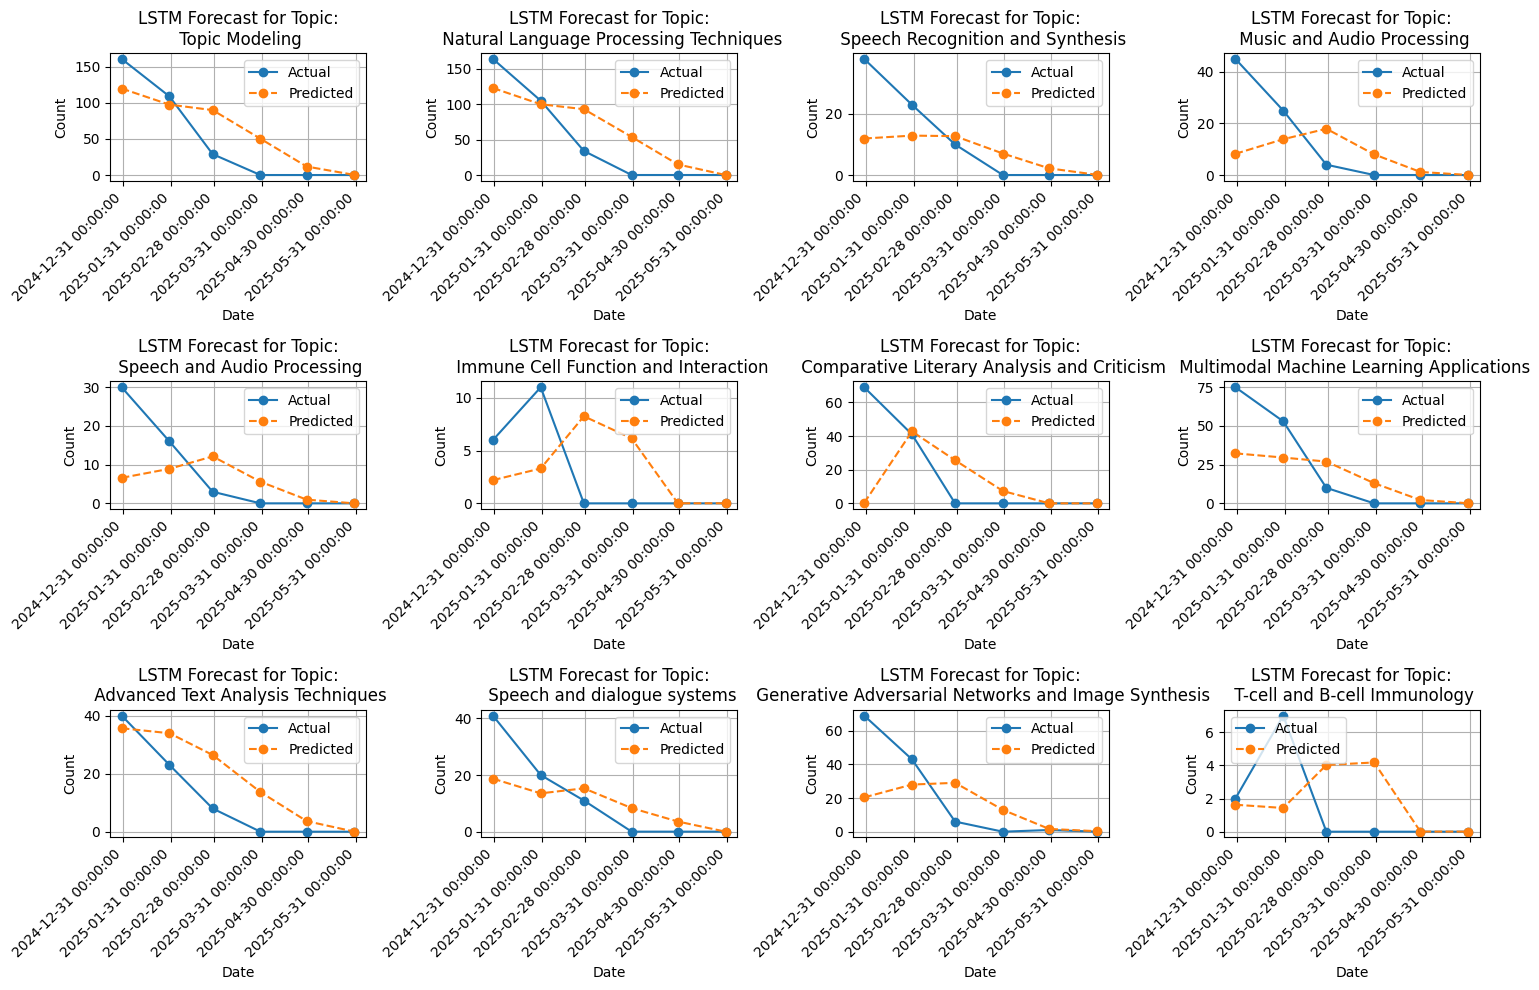


=== Average MAE Across Topics: 13.24 ===
=== Average RMSE Across Topics: 18.25 ===
=== Average MAPE Across Topics: 85.96% ===
MAE, RMSE, and MAPE results saved to 'MAE_Results.txt'


In [28]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10)) 
mae_results = {}
rmse_results = {}
mape_results = {}

for idx, topic in enumerate(top_12_topics):
    row, col = divmod(idx, 4)
    
    print(f"=== Forecasting for topic: {topic} ===")
    
    model, mae, rmse, mape, y_test_inv, y_pred_test_inv, test_dates = lstm_forecast_for_topic(
        monthly_counts, topic, best_params['lookback'], test_size=6, 
        lstm_units=best_params['lstm_units'], batch_size=best_params['batch_size'], 
        learning_rate=best_params['learning_rate'], epochs=best_params['epochs']
    )
    
    mae_results[topic] = mae
    rmse_results[topic] = rmse
    mape_results[topic] = mape
    
    ax = axes[row, col]
    ax.plot(test_dates, y_test_inv, label="Actual", marker="o", linestyle="-")
    ax.plot(test_dates, y_pred_test_inv, label="Predicted", marker="o", linestyle="--")
    ax.set_title(f'LSTM Forecast for Topic:\n {topic}')
    ax.set_xlabel("Date")
    ax.set_ylabel("Count")
    ax.legend()
    ax.grid()
    ax.set_xticklabels(test_dates, rotation=45, ha='right')

plt.tight_layout()
plt.savefig("LSTM_Top_12_Topics1.png", dpi=300, bbox_inches="tight")
plt.show()

average_mae = np.mean(list(mae_results.values()))
average_rmse = np.mean(list(rmse_results.values()))
average_mape = np.mean(list(mape_results.values()))

print(f"\n=== Average MAE Across Topics: {average_mae:.2f} ===")
print(f"=== Average RMSE Across Topics: {average_rmse:.2f} ===")
print(f"=== Average MAPE Across Topics: {average_mape:.2f}% ===")

with open("MAE_Results.txt", "w") as f:
    f.write("MAE, RMSE, and MAPE Results for Each Topic:\n")
    for topic in mae_results.keys():
        f.write(f"{topic}: MAE = {mae_results[topic]:.2f}, RMSE = {rmse_results[topic]:.2f}, MAPE = {mape_results[topic]:.2f}%\n")
    f.write(f"\n=== Average MAE Across Topics: {average_mae:.2f} ===\n")
    f.write(f"=== Average RMSE Across Topics: {average_rmse:.2f} ===\n")
    f.write(f"=== Average MAPE Across Topics: {average_mape:.2f}% ===\n")

print("MAE, RMSE, and MAPE results saved to 'MAE_Results.txt'")